# D7046E Neural Networks and Learning Machines


## Import Libraries

In [ ]:
!pip install snntorch
!pip install tonic
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tonic
import torch
import torch.nn as nn
import snntorch as snn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from collections import Counter
from tonic import transforms
from IPython.display import HTML
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

In [ ]:
# use gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Dataset
Load the DVS Gesture dataset, a neuromorphic dataset of event-based hand gesture recordings, using the tonic library

In [ ]:
# load train and test splits
train_set = tonic.datasets.DVSGesture(save_to='./data', train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', train=False)

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture


## Exploratory Data Analysis


### Understanding the Dataset
Basic information about the dataset, including the number of samples in the training set and test set

Show the name of the target gesture by mapping the target index to the corresponding category in `train_set.classes`, followed by the number of events in that sample and the names of the attributes in the events data structure

In [ ]:
# basic info
print(f"Number of train samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")
print(f"Gesture categories: {train_set.classes}")

# inspect a single sample
sample_idx = 0
events, target = train_set[sample_idx]
print(f"Sample {sample_idx} - Target gesture: {train_set.classes[target]}")
print(f"Number of events in sample: {len(events)}")
print(f"Event attributes: {events.dtype.names}")

Number of train samples: 1077
Number of test samples: 264
Gesture categories: ['Hand clapping', 'Right hand wave', 'Left hand wave', 'Right arm cw', 'Right arm ccw', 'Left arm cw', 'Left arm ccw', 'Arm roll', 'Air drums', 'Air guitar', 'Other gestures']
Sample 0 - Target gesture: Arm roll
Number of events in sample: 357964
Event attributes: ('x', 'y', 'p', 't')


### Visualize Data
Visualizes the first sample from the train_set of the DVS Gesture dataset by extracting the event data (a sequence of timestamped pixel changes) and its corresponding gesture label. The extraction is then followed by converting the raw events into a series of 100 time-binned frames, using the dataset’s predefined sensor size. Applying this with `frames = to_frame(events)` generates a tensor of shape (100, channels, height, width), representing the event data as a stack of frames

(100, 2, 128, 128) 7


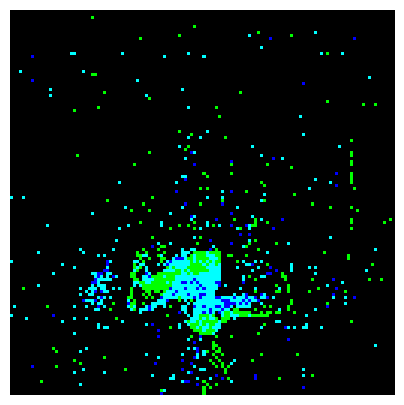

In [ ]:
events, label = train_set[0]

to_frame = transforms.ToFrame(sensor_size=tonic.datasets.DVSGesture.sensor_size, n_time_bins=100)
frames = to_frame(events)

print(frames.shape, label)
animation = tonic.utils.plot_animation(frames)
HTML(animation.to_jshtml())

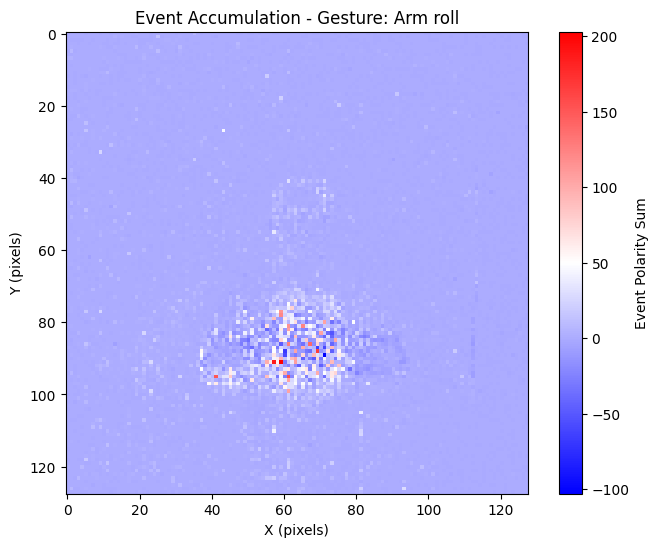

In [ ]:
# visualize events for the first sample
events, target = train_set[0]

# convert events to a frame for visualization (accumulate events over time)
frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]), dtype=int)
for event in events:
    frame[event['y'], event['x']] += 1 if event['p'] else -1  # +ve/-ve polarity

plt.figure(figsize=(8, 6))
plt.imshow(frame, cmap='bwr', interpolation='nearest')
plt.title(f"Event Accumulation - Gesture: {train_set.classes[target]}")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label="Event Polarity Sum")
plt.show()

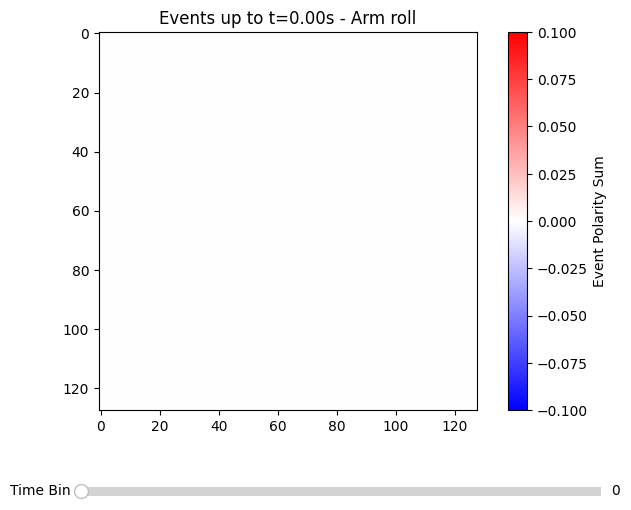

In [ ]:
from matplotlib.widgets import Slider

events, target = train_set[0]
time_bins = np.linspace(events['t'].min(), events['t'].max(), 100)  # split into 100 time bins

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(bottom=0.25)
frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]))
initial_bin = 0
mask = (events['t'] < time_bins[initial_bin])
for event in events[mask]:
    frame[event['y'], event['x']] += 1 if event['p'] else -1
im = ax.imshow(frame, cmap='bwr', interpolation='nearest')
ax.set_title(f"Events up to t={time_bins[initial_bin]/1e6:.2f}s - {train_set.classes[target]}")
plt.colorbar(im, ax=ax, label="Event Polarity Sum")

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(ax_time, 'Time Bin', 0, len(time_bins)-1, valinit=initial_bin, valstep=1)

def update(val):
    bin_idx = int(time_slider.val)
    frame = np.zeros((train_set.sensor_size[1], train_set.sensor_size[0]))
    mask = (events['t'] < time_bins[bin_idx])
    for event in events[mask]:
        frame[event['y'], event['x']] += 1 if event['p'] else -1
    im.set_data(frame)
    ax.set_title(f"Events up to t={time_bins[bin_idx]/1e6:.2f}s - {train_set.classes[target]}")
    fig.canvas.draw_idle()

time_slider.on_changed(update)
plt.show()

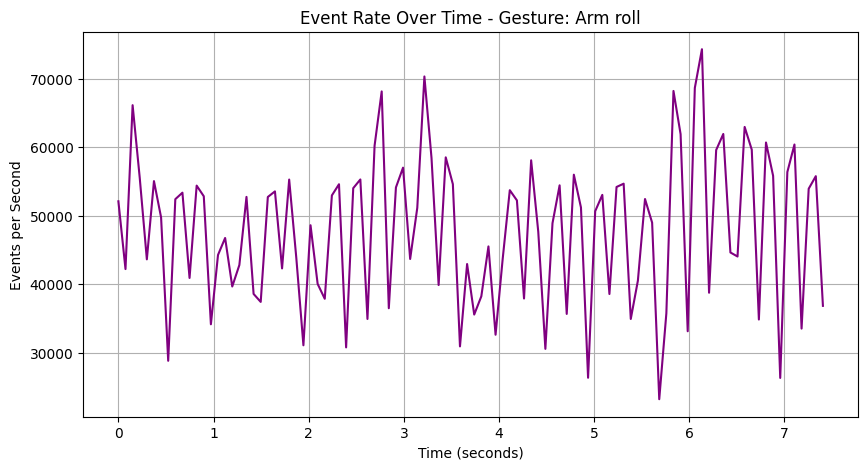

In [ ]:
events, target = train_set[0]
times = events['t'] / 1e6
hist, bin_edges = np.histogram(times, bins=100)
event_rate = hist / np.diff(bin_edges)

plt.figure(figsize=(10, 5))
plt.plot(bin_edges[:-1], event_rate, color='purple')
plt.title(f"Event Rate Over Time - Gesture: {train_set.classes[target]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Events per Second")
plt.grid(True)
plt.show()

## Feature Engineering

- Denoise to filter out noise with a 10,000-unit time threshold
- Downsample to reduce the spatial resolution from the original sensor size to 32x32
- ToFrame to convert event-based data into 100 time-binned frames with a 32x32x2 sensor size (accounting for two polarities)

In [ ]:
transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000),
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(32, 32)),
    tonic.transforms.ToFrame(sensor_size=(32, 32, 2), n_time_bins=100),
])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=transforms, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=transforms, train=False)

cached_train_set = tonic.cached_dataset.DiskCachedDataset(train_set, cache_path='./cache/train')
cached_test_set = tonic.cached_dataset.DiskCachedDataset(test_set, cache_path='./cache/test')

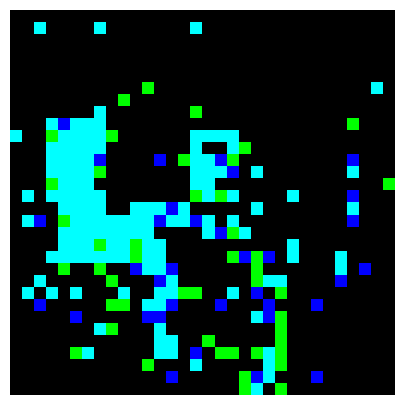

(100, 2, 32, 32) 3


In [ ]:
from IPython.display import HTML

frames, label = cached_train_set[1]
animation = tonic.utils.plot_animation(frames)
print(frames.shape, label)
HTML(animation.to_jshtml())

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(cached_train_set))
val_size = len(cached_train_set) - train_size
train_set, val_set = random_split(cached_train_set, [train_size, val_size])

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True,
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
val_loader = DataLoader(val_set, batch_size=32,shuffle=True, drop_last=True,
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(cached_test_set, batch_size=32, shuffle=True, drop_last=True,
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

## Model Training and Optimization

The network is defined as a sequential model with several layers:

- Convolutional layers (nn.Conv2d) and max pooling layers (nn.MaxPool2d) to process spatial features
- Leaky Integrate-and-Fire (LIF) neuron layers (snn.Leaky) introduces temporal dynamics by simulating how neurons accumulate and fire based on input
- Fully connected layer (nn.Linear) and another LIF layer given the output is spike-based for classification into 11 classes


In traditional neural networks, backpropagation relies on differentiable activation functions. However, in SNNs, neurons generate spikes (binary outputs: 0 or 1) based on a threshold, making the spike function non-differentiable. This poses a challenge for gradient-based optimization. A surrogate gradient is used as a smooth approximation of the spike function’s derivative during backpropagation. Here, surrogate.atan() suggests that the arctangent (atan) function is employed as this approximation. The atan function is continuous and differentiable, allowing gradients to flow backward through the network even though the forward pass involves discrete spikes.


With beta = 0.5, the membrane potential retains 50% of its value from the previous time step before adding new inputs. A higher beta (closer to 1) means slower decay, while a lower beta (closer to 0) means faster decay.

In [ ]:
# used to calculate gradient as spike function is non-differentiable, allowing backpropagation in SNN training
spike_grad = surrogate.atan()

# set the leak rate for LIF neurons, controlling how quickly their membrane potential decays over time
beta = 0.5

net = nn.Sequential(
    # extracts spatial features from the input by sliding filters across it
    nn.Conv2d(2, 12, 5), # in_channels, out_channels, kernel_size
    # reduces the spatial dimensions of the feature maps by half, keeping the maximum value in each 2x2 region
    nn.MaxPool2d(2),
    # converts continuous output into spikes by processesing inputs over time, producing a spike if the membrane potential crosses a threshold
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

    # extracts higher-level features from the previous layer’s output.
    nn.Conv2d(12, 32, 5),
    # further reduces spatial dimensions, focusing on the most prominent features
    nn.MaxPool2d(2),
    # applies spiking dynamics to the second conv layer’s output, same as the first LIF layer
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

    # collapses the 2D feature maps into a 1D vector
    nn.Flatten(),

    # maps the flattened features to the 11 output classes
    nn.Linear(800, 11),

    # generates the final spike trains for each of the 11 classes over time
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))

# encourages correct class neurons to spike 80% of the time and incorrect ones 20%, based on spike counts
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [ ]:
def validate_model():
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        net.eval()
        for batch, (data, targets) in enumerate(iter(val_loader)):
            data, targets = data.to(device), targets.to(device)
            spk_rec = forward_pass(net, data)
            val_loss += loss_fn(spk_rec, targets).item() * data.shape[0]
            correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
            total += data.shape[0]
        val_loss /= total
    return correct / total, val_loss

Epoch 0, Iteration 0
Train Accuracy: 18.75%
Train Loss: 9.45
Validation Loss: 9.45
Validation Accuracy: 8.33%

Epoch 0, Iteration 1
Train Accuracy: 9.38%
Train Loss: 9.45
Validation Loss: 8.59
Validation Accuracy: 13.02%

Epoch 0, Iteration 2
Train Accuracy: 9.38%
Train Loss: 8.76
Validation Loss: 6.12
Validation Accuracy: 6.77%

Epoch 0, Iteration 3
Train Accuracy: 6.25%
Train Loss: 6.29
Validation Loss: 11.88
Validation Accuracy: 6.77%

Epoch 0, Iteration 4
Train Accuracy: 9.38%
Train Loss: 13.36
Validation Loss: 6.82
Validation Accuracy: 11.46%

Epoch 0, Iteration 5
Train Accuracy: 9.38%
Train Loss: 6.86
Validation Loss: 5.23
Validation Accuracy: 15.62%

Epoch 0, Iteration 6
Train Accuracy: 28.12%
Train Loss: 5.60
Validation Loss: 6.23
Validation Accuracy: 21.88%

Epoch 0, Iteration 7
Train Accuracy: 40.62%
Train Loss: 6.27
Validation Loss: 6.78
Validation Accuracy: 23.96%

Epoch 0, Iteration 8
Train Accuracy: 37.50%
Train Loss: 7.20
Validation Loss: 6.46
Validation Accuracy: 21.88%

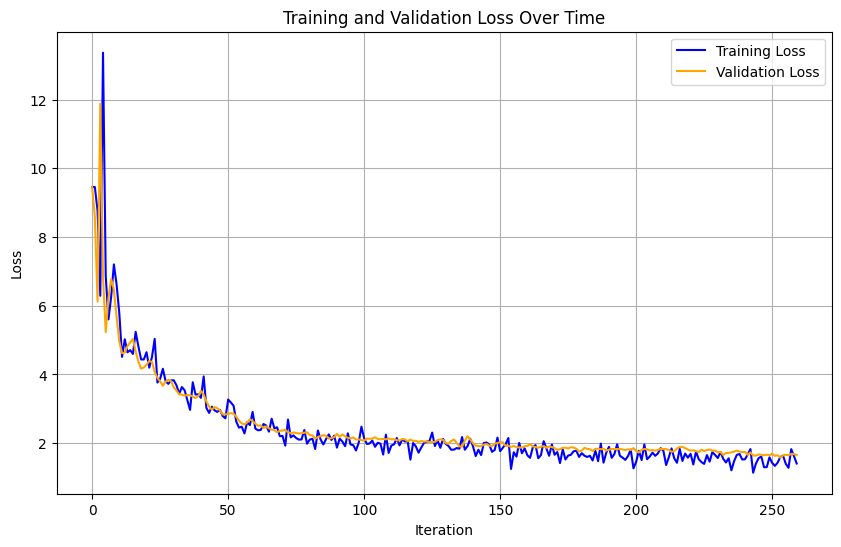

In [ ]:
num_epochs = 10
num_iters = 50

for epoch in range(num_epochs):
    for batch, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        net.train()

        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss = loss_fn(spk_rec, targets)

        # gradient calculation and weight update
        loss.backward()
        optimizer.step()

        # store loss history for future plotting
        loss_hist.append(loss.item())

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        print(f"Epoch {epoch}, Iteration {batch}")
        print(f"Train Accuracy: {acc * 100:.2f}%")
        print(f"Train Loss: {loss.item():.2f}")
        val_acc, val_loss = validate_model()
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        print(f"Validation Loss: {val_loss:.2f}")
        print(f"Validation Accuracy: {val_acc * 100:.2f}%\n")

        if batch == num_iters:
          break

net.to('cpu')
torch.save(net.state_dict(), 'best.pt')
print("Model weights saved to 'best.pt'")

plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label='Training Loss', color='blue')
plt.plot(val_loss_hist, label='Validation Loss', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

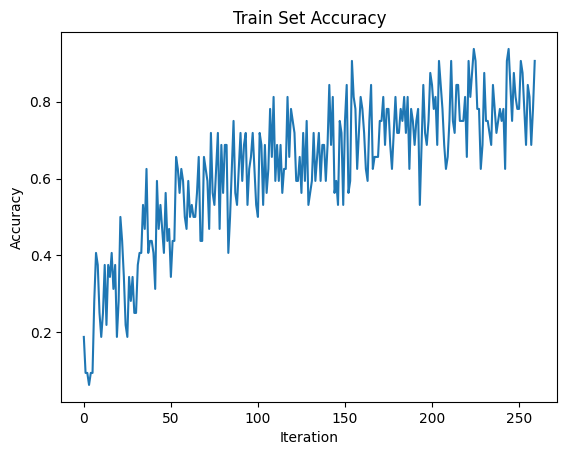

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

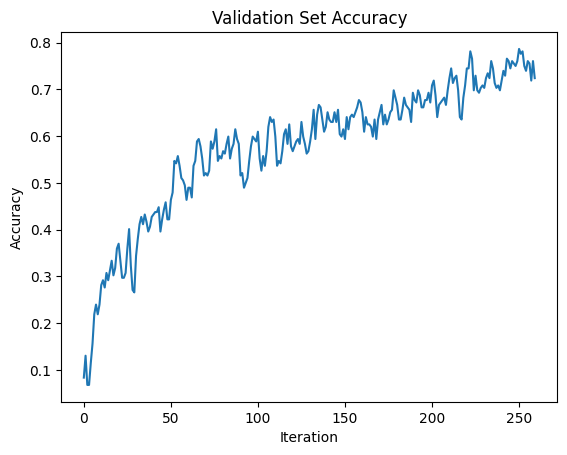

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(val_acc_hist)
plt.title("Validation Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## Testing and Evaluation


In [ ]:
def test_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)  # pass data back to gpu
    correct, total = 0, 0
    for batch, (data, targets) in enumerate(iter(test_loader)):
        data, targets = data.to(device), targets.to(device)
        spk_rec = forward_pass(net, data)
        correct += SF.accuracy_rate(spk_rec, targets) * data.size(1)
        total += data.size(1)
    return correct / total

test_acc = test_model()
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 75.00%


Showing that the model can respond to specific movements and correctly label them.

The DVSGesture dataset has 11 hand movements: "Hand Clap", "Right Hand Wave", "Left Hand Wave", "Right Arm Clockwise", "Right Arm Counterclockwise", "Left Arm Clockwise", "Left Arm Counterclockwise", "Arm Roll", "Air Drums", "Air Guitar" and "Other Gesture"

We will load 5 random events, and the model will attempt to label the corresponding movement.


🔹 Sample 1:
True Movement: Air Drums
Predicted Movement: Air Guitar


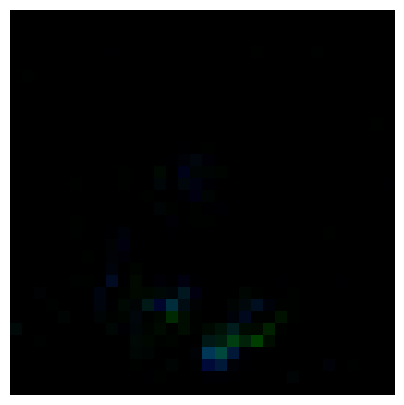


🔹 Sample 2:
True Movement: Hand Clap
Predicted Movement: Hand Clap


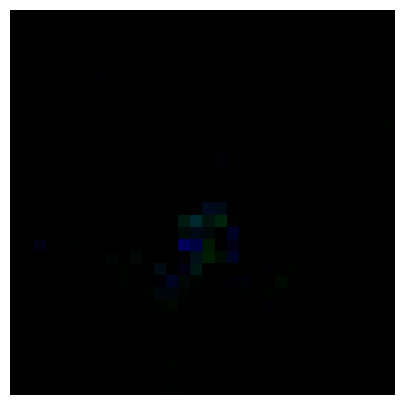


🔹 Sample 3:
True Movement: Air Guitar
Predicted Movement: Air Guitar


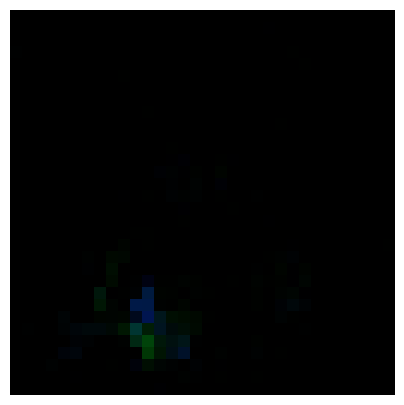


🔹 Sample 4:
True Movement: Hand Clap
Predicted Movement: Hand Clap


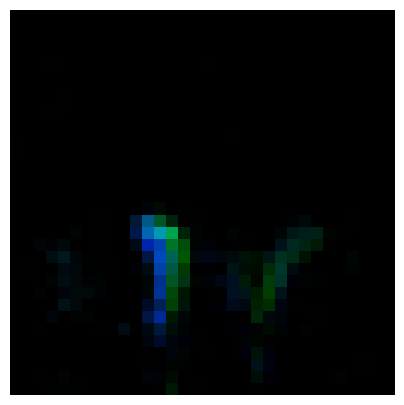


🔹 Sample 5:
True Movement: Air Guitar
Predicted Movement: Air Drums


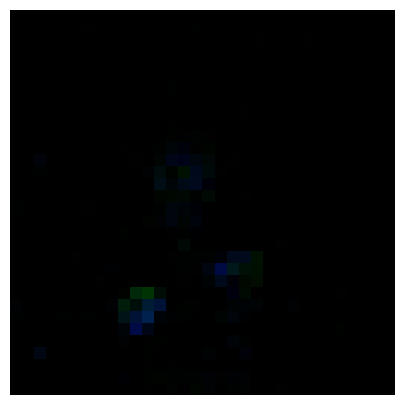

In [ ]:
movement_labels = [
    "Hand Clap", "Right Hand Wave", "Left Hand Wave", "Right Arm Clockwise", "Right Arm Counterclockwise",
    "Left Arm Clockwise", "Left Arm Counterclockwise", "Arm Roll", "Air Drums", "Air Guitar", "Other Gesture"
]

def predict_and_display(num_samples=5):
    net.eval()  # Set model to evaluation mode

    with torch.no_grad():
        indices = random.sample(range(len(test_loader.dataset)), num_samples)  # select 5 random indices

        for i, idx in enumerate(indices):
            frames, true_label = test_loader.dataset[idx]  # load a random test sample

            input_data = torch.tensor(frames, dtype=torch.float32).unsqueeze(0).to(device)

            # Reset hidden states for the SNN
            snn.utils.reset(net)

            # Forward pass through the network
            spk_rec = []
            for step in range(input_data.size(1)):  # Iterate over time steps
                spk_out, _ = net(input_data[:, step])  # Process one time step at a time
                spk_rec.append(spk_out)

            spk_rec = torch.stack(spk_rec).mean(dim=0)  # Average spikes over time
            predicted_class = torch.argmax(spk_rec).item()  # Get class with most spikes

            # normalise frames before displaying so matplotlib warnings are not displayed
            frames = normalize_frames(frames)

            # display the animation with labels
            display_sequence(frames, predicted_class, true_label, i + 1)

# function to normalize frames to [0,1] range
def normalize_frames(frames):
    frames = np.array(frames)
    frames = (frames - frames.min()) / (frames.max() - frames.min())  # Normalize between 0 and 1
    return frames

# function to show animation using tonic.utils.plot_animation without initial frame
def display_sequence(frames, predicted_class, true_class, sample_num):
    print(f"\n🔹 Sample {sample_num}:")
    print(f"True Movement: {movement_labels[true_class]}")
    print(f"Predicted Movement: {movement_labels[predicted_class]}")

    animation = tonic.utils.plot_animation(frames)  # Generate animation
    display(HTML(animation.to_jshtml()))  # Show animation in Jupyter Notebook

predict_and_display(num_samples=5)